In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#importing the required libraries
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Load the model vgg19 that will serve as the base model
model=models.vgg19(pretrained=True).features
# the vgg19 model has three components:
    #features: containg all the conv, relu and maxpool
    #avgpool: containing the avgpool layer
    #classifier: contains the Dense layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.5MB/s]


In [7]:
#Assigning the GPU to the variable device
device=torch.device("cuda")

In [8]:
#[0,5,10,19,28] are the index of the layers we will be using
# to calculate the loss as per the NST paper.
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        # Here we will use the following layers and make an array
        # of their indices:
        # 0: block1_conv1
        # 5: block2_conv1
        # 10: block3_conv1
        # 19: block4_conv1
        # 28: block5_conv1
        self.req_features= ['0','5','10','19','28']
        # Since we need only the 5 layers in the model,
        # we will be dropping the rest of the layers
        self.model=models.vgg19(pretrained=True).features[:29]

    # x holds the input tensor(image) that will be fed to each layer
    def forward(self,x):
        # Initialize an array that wil hold the activations from the chosen layers
        features=[]
        # Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            # Activation of this layer will be fed to the next
            x=layer(x)
            # Append the activation of the selected layers and
            # return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)

        return features

In [9]:
# Load the image, preprocess and put it on the GPU
def image_loader(orig_path, style_path):
    orig_image=Image.open(orig_path)
    style_image=Image.open(style_path)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(orig_image)
    axarr[0,1].imshow(style_image)

    # Dimensions of the generated picture.
    width, height = orig_image.size
    img_height = 512
    img_width = int(width * img_height / height)

    # Transformation steps before feeding image to the model:
    # Resizing and then converting it to a tensor
    loader=transforms.Compose([transforms.Resize((img_height,img_width)),transforms.ToTensor()])

    orig_image=loader(orig_image)
    axarr[1,0].imshow(  orig_image.permute(1, 2, 0)  )
    orig_image=orig_image.unsqueeze(0)
    style_image=loader(style_image)
    axarr[1,1].imshow(  style_image.permute(1, 2, 0)  )
    style_image=style_image.unsqueeze(0)
    return orig_image.to(device,torch.float), style_image.to(device,torch.float)

In [10]:
def calc_content_loss(gen_feat,orig_feat):
    # Calculating the content loss of each layer by calculating
    # the MSE between the content and generated features
    content_l=torch.mean((gen_feat-orig_feat)**2)
    return content_l

In [11]:
def calc_style_loss(gen,style):
    # Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())

    # Calcultating the style loss of each layer by calculating the MSE
    # between the gram matrix of the style image and the generated image
    style_l=torch.mean((G-A)**2)
    return style_l

In [12]:
def calculate_loss(gen_features, orig_features, style_features):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_features,style_features):
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)

    # Calculating the total loss of the epoch
    total_loss=alpha*content_loss + beta*style_loss
    return total_loss

In [13]:
for i in range(10):
    !wget "https://github.com/DwayneHuang/Night-View/raw/main/{i+1}.jpg" -O "night_view_{i+1}.jpg"
    !wget "https://github.com/DwayneHuang/Grimshaw/raw/main/{i+1}.jpg" -O "grimshaw_{i+1}.jpg"

--2024-04-16 01:08:50--  https://github.com/DwayneHuang/Night-View/raw/main/1.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DwayneHuang/Night-View/main/1.jpg [following]
--2024-04-16 01:08:51--  https://raw.githubusercontent.com/DwayneHuang/Night-View/main/1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39045 (38K) [image/jpeg]
Saving to: ‘night_view_1.jpg’

night_view_1.jpg    100%[===================>]  38.13K  --.-KB/s    in 0.002s  

2024-04-16 01:08:51 (15.5 MB/s) - ‘night_view_1.jpg’ saved [39045/39045]

--2024-04-16 01:08:51--  https://github.com/DwayneHuang/Grimshaw/raw/main/

In [14]:
import os
# Create a new folder to store the generated images
output_folder = "VGG19_ouput"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

tensor(5.6479e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(89585304., device='cuda:0', grad_fn=<AddBackward0>)
tensor(25553906., device='cuda:0', grad_fn=<AddBackward0>)
tensor(14683802., device='cuda:0', grad_fn=<AddBackward0>)
tensor(10040389., device='cuda:0', grad_fn=<AddBackward0>)
tensor(7475666.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5825632., device='cuda:0', grad_fn=<AddBackward0>)
tensor(4671814.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3824852.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3199461.7500, device='cuda:0', grad_fn=<AddBackward0>)


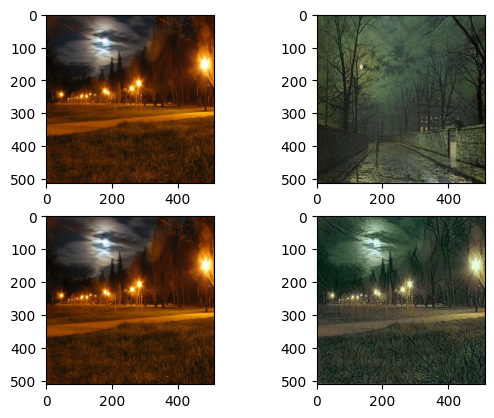

tensor(1.7021e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9508e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1507e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7339e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5025e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3310e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1888e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0660e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(95783632., device='cuda:0', grad_fn=<AddBackward0>)
tensor(86195040., device='cuda:0', grad_fn=<AddBackward0>)


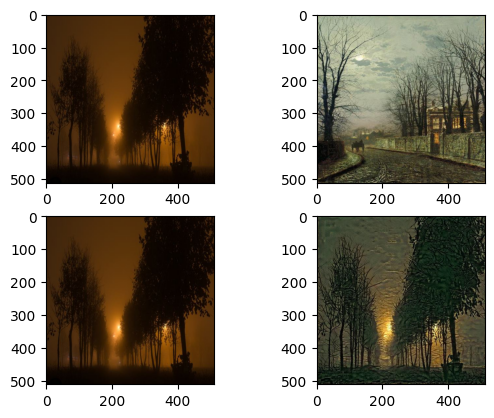

tensor(5.5545e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1581e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(86364176., device='cuda:0', grad_fn=<AddBackward0>)
tensor(65516996., device='cuda:0', grad_fn=<AddBackward0>)
tensor(48893052., device='cuda:0', grad_fn=<AddBackward0>)
tensor(35874200., device='cuda:0', grad_fn=<AddBackward0>)
tensor(25986344., device='cuda:0', grad_fn=<AddBackward0>)
tensor(18671056., device='cuda:0', grad_fn=<AddBackward0>)
tensor(13373039., device='cuda:0', grad_fn=<AddBackward0>)
tensor(9611446., device='cuda:0', grad_fn=<AddBackward0>)


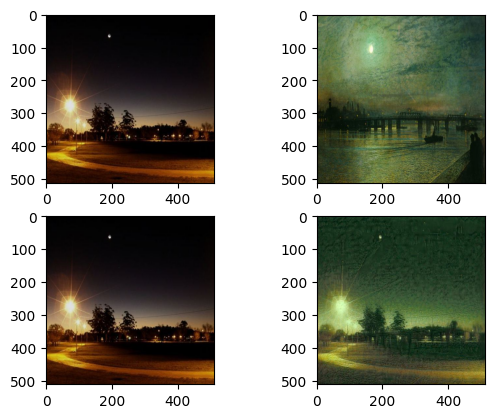

tensor(8.2179e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.2348e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(84005416., device='cuda:0', grad_fn=<AddBackward0>)
tensor(40683956., device='cuda:0', grad_fn=<AddBackward0>)
tensor(24303262., device='cuda:0', grad_fn=<AddBackward0>)
tensor(16580185., device='cuda:0', grad_fn=<AddBackward0>)
tensor(12209291., device='cuda:0', grad_fn=<AddBackward0>)
tensor(9485623., device='cuda:0', grad_fn=<AddBackward0>)
tensor(7697484., device='cuda:0', grad_fn=<AddBackward0>)
tensor(6442684.5000, device='cuda:0', grad_fn=<AddBackward0>)


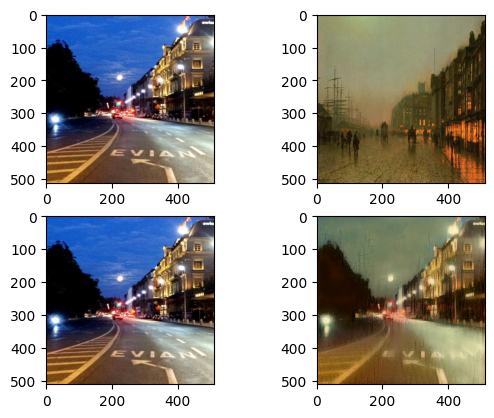

tensor(2.1945e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(47545520., device='cuda:0', grad_fn=<AddBackward0>)
tensor(30805696., device='cuda:0', grad_fn=<AddBackward0>)
tensor(21096430., device='cuda:0', grad_fn=<AddBackward0>)
tensor(14422156., device='cuda:0', grad_fn=<AddBackward0>)
tensor(9943013., device='cuda:0', grad_fn=<AddBackward0>)
tensor(6835122.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4845513., device='cuda:0', grad_fn=<AddBackward0>)
tensor(3669500.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3181075., device='cuda:0', grad_fn=<AddBackward0>)


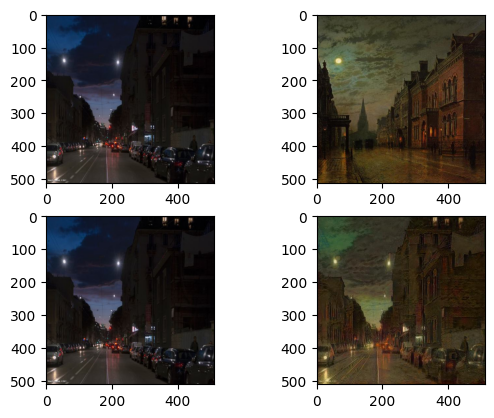

tensor(3.9566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5348e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3338e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4619e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8723e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4902e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1683e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8768e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6064e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3544e+08, device='cuda:0', grad_fn=<AddBackward0>)


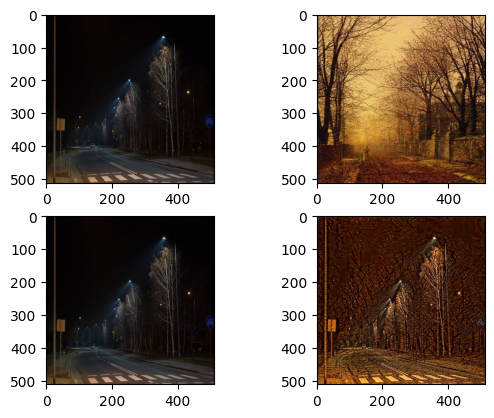

tensor(4.9246e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3139e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(90212312., device='cuda:0', grad_fn=<AddBackward0>)
tensor(71800208., device='cuda:0', grad_fn=<AddBackward0>)
tensor(58177776., device='cuda:0', grad_fn=<AddBackward0>)
tensor(47394544., device='cuda:0', grad_fn=<AddBackward0>)
tensor(38831204., device='cuda:0', grad_fn=<AddBackward0>)
tensor(32057166., device='cuda:0', grad_fn=<AddBackward0>)
tensor(26731482., device='cuda:0', grad_fn=<AddBackward0>)
tensor(22560322., device='cuda:0', grad_fn=<AddBackward0>)


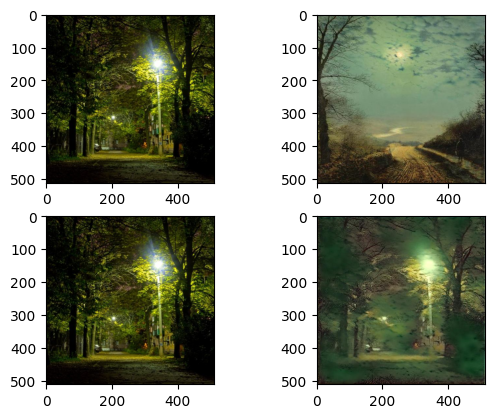

tensor(1.8218e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6026e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7089e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2355e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(97872840., device='cuda:0', grad_fn=<AddBackward0>)
tensor(80033352., device='cuda:0', grad_fn=<AddBackward0>)
tensor(66714784., device='cuda:0', grad_fn=<AddBackward0>)
tensor(56192432., device='cuda:0', grad_fn=<AddBackward0>)
tensor(47550684., device='cuda:0', grad_fn=<AddBackward0>)
tensor(40327300., device='cuda:0', grad_fn=<AddBackward0>)


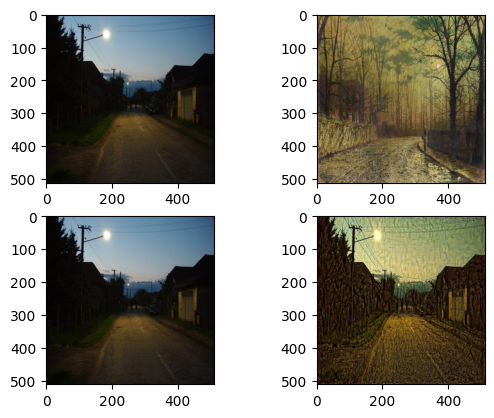

tensor(1.3628e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0447e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2683e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0258e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(87208184., device='cuda:0', grad_fn=<AddBackward0>)
tensor(75480040., device='cuda:0', grad_fn=<AddBackward0>)
tensor(65803604., device='cuda:0', grad_fn=<AddBackward0>)
tensor(57500952., device='cuda:0', grad_fn=<AddBackward0>)
tensor(50229456., device='cuda:0', grad_fn=<AddBackward0>)
tensor(43791972., device='cuda:0', grad_fn=<AddBackward0>)


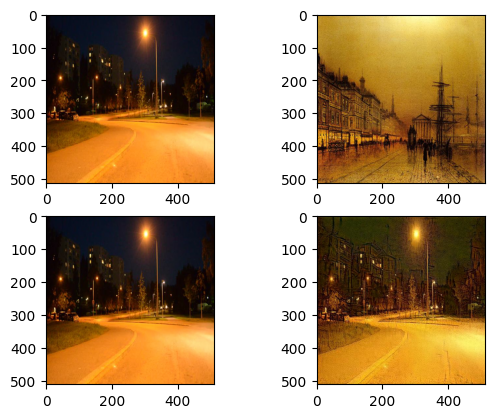

tensor(2.1859e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58101680., device='cuda:0', grad_fn=<AddBackward0>)
tensor(43407920., device='cuda:0', grad_fn=<AddBackward0>)
tensor(32321706., device='cuda:0', grad_fn=<AddBackward0>)
tensor(23683716., device='cuda:0', grad_fn=<AddBackward0>)
tensor(17212180., device='cuda:0', grad_fn=<AddBackward0>)
tensor(12475279., device='cuda:0', grad_fn=<AddBackward0>)
tensor(9132757., device='cuda:0', grad_fn=<AddBackward0>)
tensor(16565002., device='cuda:0', grad_fn=<AddBackward0>)
tensor(5502758., device='cuda:0', grad_fn=<AddBackward0>)


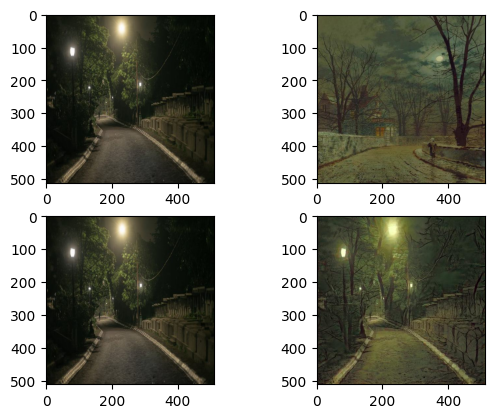

In [15]:
# Adjust hyperparameters
epoch=1000
lr=0.004
alpha=8
beta=100

# Generate 10 images in a loop
for i in range(10):
    # Loading the original and the style image
    original_image, style_image = image_loader(f'night_view_{i+1}.jpg', f'grimshaw_{i+1}.jpg')

    # Creating the generated image from the original image
    generated_image=original_image.clone().requires_grad_(True)

    # Load the model to the GPU
    model=VGG().to(device).eval()

    # Run reference images through the model once
    orig_features = model(original_image)
    style_features = model(style_image)
    # Using adam optimizer to update the generated image
    # (not the model parameters!)
    optimizer=optim.Adam([generated_image],lr=lr)


    # Iterating for 1000 times
    for e in range (epoch):
        optimizer.zero_grad()
        # Extracting the features of generated image required for
        # calculating the loss.
        gen_features=model(generated_image)

        # Iterate over the activation of each layer and calculate the loss
        total_loss=calculate_loss(gen_features, orig_features, style_features)

        # Retain graph, since otherwise orig_features and style_features would
        # be thrown away after, but we need them for each iteration
        total_loss.backward(retain_graph=True)
        # optimize the pixel values of the generated image and backpropagate the loss
        optimizer.step()

        # Save image after each 100 epochs
        if(not (e%100)):
            print(total_loss)

            #save_image(generated_image,"gen.jpg")
            save_image(generated_image, os.path.join(output_folder, f"gen{i+1}_epoch{epoch}_lr{lr}_alpha{alpha}_beta{beta}.jpg"))

    img = plt.imread(os.path.join(output_folder, f"gen{i+1}_epoch{epoch}_lr{lr}_alpha{alpha}_beta{beta}.jpg"))
    plt.imshow(img)
    plt.show()

In [ ]:
import shutil
# Download files to Google Drive
shutil.copytree('/content/VGG19_ouput', '/content/drive/My Drive/VGG19_ouput')

'/content/drive/My Drive/VGG19_ouput4'